In [39]:
import numpy as np
from datetime import datetime
from dlm_functions import computeAnormaly,forwardFilteringM, Model,PlotEWS


import scipy.linalg
from scipy.stats import t as tdstr
from scipy.stats import norm
from scipy.interpolate import interp1d
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib
matplotlib.rc('font', size=14)
import matplotlib.pyplot as plt

In [24]:
# NDVI time seires
N = np.loadtxt('Inputs/NDVI.txt') # 16天间隔的NDVI
fill_value = -999

# climate conditions in order: 
# precipitation plus snowmelt (mm/day)  
# air temperature (degree C)
# vapor pressure deficit (kPa)
# net shortwave radiation (W/m2)
CLM = np.loadtxt('Inputs/CLM.txt') # 16天间隔的climate factors

# daily averages of climate conditions in the same order
AvgCLM = np.loadtxt('Inputs/AvgCLM.txt') # 365天 daily averaged climates 

In [34]:
AvgCLM

<function forwardFilteringM at 0x1075c8400>


In [25]:
# compute climate anomaly within each interval of two NDVI observations
date0 = datetime(1999,6,30) # the data of first NDVI obervation
anCLM = computeAnormaly(CLM,AvgCLM,date0) # 计算气象因素的异常值,16天的数据与对应期间年平均数据的差值

In [26]:
# center NDVI time series
N[N==fill_value] = np.nan
Y = N[1:]-np.nanmean(N) # 不理解为什么不是从N[0:]开始, 好像是要用当期的环境因素预测下一期的NDVI

In [42]:
# use two seasonal harmonic components # 使用两个季节性谐波分量
rseas = [1,2] 

# include lag-1 centerred NDVI and precipitation in the regression module #只包含上起的NDVI和降水
X = np.column_stack((N[:-1]-np.nanmean(N),anCLM[:-1,0])) 

# set up model and run forward filtering
delta = 0.98
M = Model(Y,X,rseas,delta) # 构建模型
FF = forwardFilteringM(M) # 求解模型

--------------- [[ 0.00000000e+00 -1.07381320e-02]
 [ 0.00000000e+00 -5.36906601e-03]
 [ 0.00000000e+00 -1.31959711e-04]
 [ 0.00000000e+00  4.47645879e-03]
 [ 0.00000000e+00 -5.36906601e-03]
 [ 0.00000000e+00  1.23636517e-19]
 [ 0.00000000e+00 -5.36906601e-03]
 [ 0.00000000e+00 -1.44402802e-19]] [[-1.07381320e-02]
 [-5.36906601e-03]
 [-1.31959711e-04]
 [ 4.47645879e-03]
 [-5.36906601e-03]
 [ 1.23636517e-19]
 [-5.36906601e-03]
 [-1.44402802e-19]]
--------------- [[ 0.00000000e+00 -1.07381320e-02 -3.33712556e-02]
 [ 0.00000000e+00 -5.36906601e-03 -1.48883077e-02]
 [ 0.00000000e+00 -1.31959711e-04  4.73655869e-04]
 [ 0.00000000e+00  4.47645879e-03  3.36320180e-03]
 [ 0.00000000e+00 -5.36906601e-03 -3.93884681e-03]
 [ 0.00000000e+00  1.23636517e-19 -2.07704857e-03]
 [ 0.00000000e+00 -5.36906601e-03 -4.78017331e-03]
 [ 0.00000000e+00 -1.44402802e-19 -3.99773830e-03]] [[-0.03337126]
 [-0.01488831]
 [ 0.00047366]
 [ 0.0033632 ]
 [-0.00393885]
 [-0.00207705]
 [-0.00478017]
 [-0.00399774]]
----

(-0.02, 0.02)

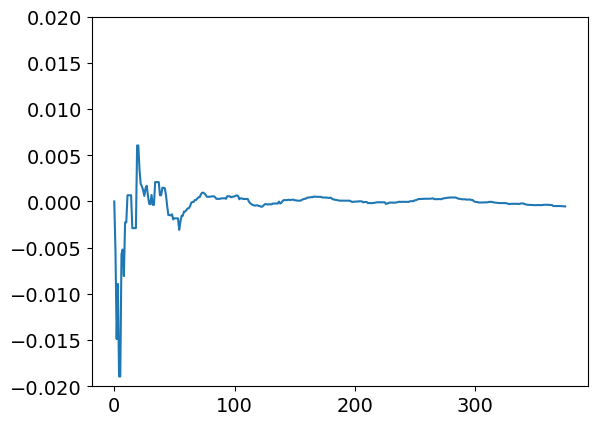

In [72]:
plt.plot(FF.get('sm')[1,:])
# plt.xlim(0, 6)  # 设置x轴刻度范围为0到6
plt.ylim(-0.02, 0.02) # 设置y轴刻度范围为0到12

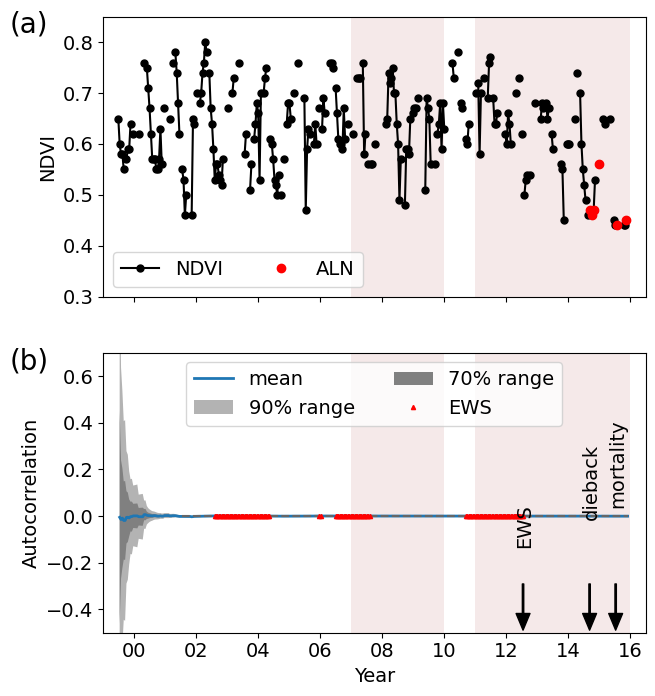

In [54]:
# extract estimates on the coefficient corresponding to lag-1 NDVI
vid = 1 # index of autocorrelation
sm = FF.get('sm')[vid,:] # mean of autocorrelation
sC = FF.get('sC')[vid,vid,:] # variance of autocorrelation
snu = FF.get('snu') # degree of freedom


# plot Fig. 1 in the manuscript
PlotEWS(N,date0,sm,sC,snu)

In [80]:
Y = M.Y # NDVI 1:374
X = M.X # NDVI 0:373 + Precp 0:373
rseas = M.rseas # [1, 2]
delta = M.delta #[0.98,0.98,0.98,0.98]
Prior = M.prior # m 全为0的列向量 均值; C: 全为1的对角矩阵; precision: 0.04; # degree of freedom
period = 365.25/16


# 全为0.8 
deltrend = delta[0];delregn = delta[1];delseas = delta[2];delvar = delta[3]

# 
Ftrend = np.array([[1],[0]]) # 关联隐变量的矩阵
ntrend = len(Ftrend) # 2
Gtrend = np.array([[1,1],[0,1]]) # 具有时间自相关的隐变量之间的关系矩阵
itrend = np.arange(0,ntrend) # 

nregn = X.shape[1] # 2个解释的因变量
Fregn = np.zeros([nregn,1])
Gregn=np.eye(nregn)
iregn = np.arange(ntrend,ntrend+nregn)

pseas = len(rseas) # 季节周期动态
nseas = pseas*2
iseas = np.arange(ntrend+nregn,ntrend+nregn+nseas)
Fseas = np.tile([[1],[0]],[pseas,1])
Gseas = np.zeros([nseas,nseas]) # 4x4的0矩阵

In [81]:
# 对于每个季节分量 按周期分别进行傅立叶转化
for j in range(pseas):
    c = np.cos(2*np.pi*rseas[j]/period);
    s = np.sin(2*np.pi*rseas[j]/period);
    i = np.arange(2*j,2*(j+1))
    Gseas[np.reshape(i,[2,1]),i] = [[c,s],[-s,c]]

In [82]:
# 合并所有转换矩阵
F = np.concatenate((Ftrend,Fregn,Fseas),axis=0)
G = scipy.linalg.block_diag(Gtrend,Gregn,Gseas) # 合并所有的对角矩阵
m = Prior.m # m 全为0的列向量 均值; 
C = Prior.C # C: 全为1的对角矩阵; 
S = Prior.S # precision: 0.04;
nu = Prior.nu # degree of freedom


T = len(Y) # Y的时间序列
sm = np.zeros(m.shape) # 隐变量均值 (自相关效应)
sC = np.zeros([C.shape[0],C.shape[1],1]) # 隐变量方差 (自相关效应)
sS = np.zeros(1) # precision
snu = np.zeros(1) # freedom
slik = np.zeros(1) # likelihood
for t in range(T):
    
    a = np.dot(G,m) # at = G mt−1: t时刻隐变量的均值 (迭代后)
    R = np.dot(np.dot(G,C),np.transpose(G)) # Rt = G·Ct−1·GT + Wt: t时刻隐变量的方差
    
    R[np.reshape(itrend,[-1,1]),itrend] = R[np.reshape(itrend,[-1,1]),itrend]/deltrend # 关联隐变量的矩阵
    R[np.reshape(iregn,[-1,1]),iregn] = R[np.reshape(iregn,[-1,1]),iregn]/delregn # 隐变量自相关的矩阵
    R[np.reshape(iseas,[-1,1]),iseas] = R[np.reshape(iseas,[-1,1]),iseas]/delseas # 周期效应的矩阵
    
    nu = delvar*nu # IG(nu/2,S*nu/2) Assuming the variation of observational error follows an inverse-gamma (IG) distribution
    
    
    F[iregn,0] = X[t,] # 关联隐变量的矩阵,iregn = np.arange(ntrend,ntrend+nregn), 2,2+2, 

    A = np.dot(R,F)
    Q = np.squeeze(np.dot(np.transpose(F),A)+S)
    A = A/Q
    f = np.squeeze(np.dot(np.transpose(F),a))
    
    y = Y[t]
    
    if ~np.isnan(y): # 如果y不是空值
        
        e = y-f # et = yt − ft # 误差error
        ac = (nu+np.power(e,2)/Q)/(nu+1)
        rQ = np.sqrt(Q)
        mlik = tdstr.pdf(e/rQ,nu)/rQ
        
        m = a+A*e # mt = at + At et; t时刻隐变量的均值 (迭代后)
        C = ac*(R-np.dot(A,np.transpose(A))*Q) # Ct = Rt − qt At AT
        nu = nu+1
        S = ac*S
        
        # About "S = ac*S" (using the notations in Liu et al. (2019)): 
        # s_t = d_t/n_t = (d_{t-1}+e_t^2/(q_t^{**}/s_t))/n_t = s_{t-1} * (n_{t-1}+e_t^2/(q_t^{**})/n_t = ac * s_{t-1}
    else: # 如果y是空值
        m = a; C = R;
        if t<T-1:
            X[t+1,0] = f
        mlik = np.nan
        
    sm = np.concatenate((sm,m),axis=1) # mean of autocorrelation 
    sC = np.concatenate((sC,np.reshape(C,[C.shape[0],C.shape[1],1])),axis=2) # variance of autocorrelation
    snu = np.concatenate((snu,[nu]),axis=0) # degree of freedom
    sS = np.concatenate((sS,[S]),axis=0)
    print('---------------',sm,m)
    slik = np.concatenate((slik,[mlik]),axis=0)

--------------- [[ 0.00000000e+00 -1.07381320e-02]
 [ 0.00000000e+00 -5.36906601e-03]
 [ 0.00000000e+00 -1.31959711e-04]
 [ 0.00000000e+00  4.47645879e-03]
 [ 0.00000000e+00 -5.36906601e-03]
 [ 0.00000000e+00  1.23636517e-19]
 [ 0.00000000e+00 -5.36906601e-03]
 [ 0.00000000e+00 -1.44402802e-19]] [[-1.07381320e-02]
 [-5.36906601e-03]
 [-1.31959711e-04]
 [ 4.47645879e-03]
 [-5.36906601e-03]
 [ 1.23636517e-19]
 [-5.36906601e-03]
 [-1.44402802e-19]]
--------------- [[ 0.00000000e+00 -1.07381320e-02 -3.33712556e-02]
 [ 0.00000000e+00 -5.36906601e-03 -1.48883077e-02]
 [ 0.00000000e+00 -1.31959711e-04  4.73655869e-04]
 [ 0.00000000e+00  4.47645879e-03  3.36320180e-03]
 [ 0.00000000e+00 -5.36906601e-03 -3.93884681e-03]
 [ 0.00000000e+00  1.23636517e-19 -2.07704857e-03]
 [ 0.00000000e+00 -5.36906601e-03 -4.78017331e-03]
 [ 0.00000000e+00 -1.44402802e-19 -3.99773830e-03]] [[-0.03337126]
 [-0.01488831]
 [ 0.00047366]
 [ 0.0033632 ]
 [-0.00393885]
 [-0.00207705]
 [-0.00478017]
 [-0.00399774]]
----